In [ ]:
!pip install persiantools

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from persiantools.jdatetime import JalaliDate
from persiantools.jdatetime import JalaliDateTime
import datetime, pytz
import math

# 0 Reading the Data

In [7]:
df = pd.read_excel('/content/drive/MyDrive/projects/maintenance/output_en.xlsx')

## 0.1 Convert Date Time to Gregorian

In [8]:
datecols = ['CFB','DFB','PS']
df[datecols] = df[datecols].applymap(lambda x: 
                                     JalaliDateTime(int(x[:4]),
                                                    int(x[5:7]),
                                                    int(x[8:10]),
                                                    int(x[11:13]),
                                                    int(x[14:])).to_gregorian() if isinstance(x,str) else None)

## 0.2 Data Head

In [ ]:
df.head(5)

,BN,TOF,AF,DS,feeder,RC,TOP,Relay,COB,PD,COP,DFB,CFB,DOFDB,PS,STOLP,EENS
0,88644,A,A,A,A,0.177419,A,A,A,NaN,NaN,2019-03-21 06:54:00,2019-03-21 06:59:00,5,NaT,NaN,0.010946
1,88645,A,B,B,B,0.145161,A,A,B,B,B,2019-03-21 07:15:00,2019-03-21 07:17:00,2,NaT,NaN,0.003127
2,88648,A,A,C,C,0.032258,A,A,C,NaN,NaN,2019-03-21 12:03:00,2019-03-21 12:45:00,42,NaT,NaN,0.016419
3,88657,A,A,A,D,0.048387,A,A,D,C,C,2019-03-22 01:20:00,2019-03-22 02:25:00,65,2019-03-22 08:15:00,415.0,0.039093
4,88664,A,C,D,A,0.161290,A,B,E,D,D,2019-03-22 16:26:00,2019-03-22 16:50:00,24,2019-03-22 22:00:00,334.0,0.075059


## 0.2 NaT Items

In [ ]:
df.loc[df.CFB.isnull(),]

,BN,TOF,AF,DS,feeder,RC,TOP,Relay,COB,PD,COP,DFB,CFB,DOFDB,PS,STOLP,EENS
944,92880,A,E,G,C,0.225806,A,F,S,M,EE,2019-09-25 09:01:00,NaT,0,2019-09-25 09:17:00,16.0,0.043002
974,93071,A,D,Y,H,0.193548,A,A,D,E,C,2019-10-04 01:00:00,NaT,0,2019-10-04 02:40:00,100.0,0.061767
1628,96284,A,D,GG,C,0.064516,A,A,D,C,C,2020-03-17 22:27:00,NaT,0,2020-03-17 22:43:00,16.0,0.012510


## 0.3 CFB DFB Sanity Check

In [ ]:
null = df[['CFB','DFB']].isnull().any(axis=1)
rule = df['CFB'] >= df['DFB']
(rule | null).unique()

array([ True])

## 0.4 PS DFB Sanity Check

In [ ]:
null = df[['PS','DFB']].isnull().any(axis=1)
rule = df['DFB'] <= df['PS']
(rule | null).unique()

array([ True])

# 1 Visualizations 

## 1.0 EENS vs STOLP 

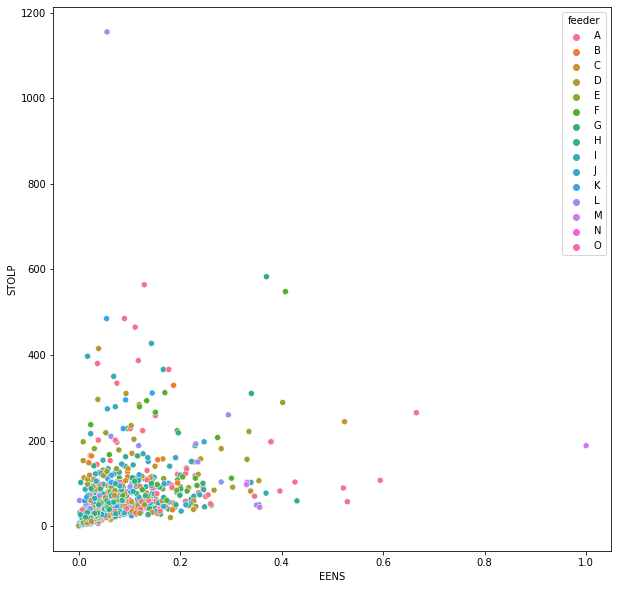

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df,x='EENS',y='STOLP',hue='feeder')

## 1.1 Correlation of Time with EENS
No variable can be used as a proxy for imputation of missing values.

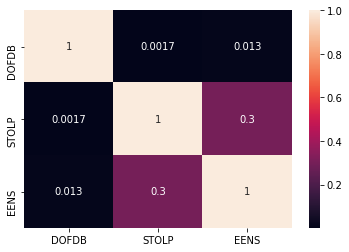

In [ ]:
sns.heatmap(df[['DOFDB','STOLP','EENS']].corr(),annot=True)

## 1.2 EENS Correlation with STOLP for each Feeder

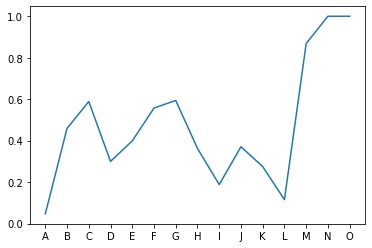

In [9]:
cats = df.feeder.unique()
corrs = [df.loc[df['feeder'] == i,].corr()['STOLP']['EENS'] for i in cats]
plt.plot(cats, corrs)

## 1.3 Visualization of Correlation Matrix (Groupped by Feeder)
**Note the high correlations**

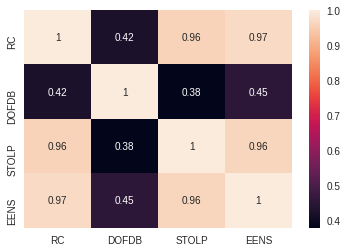

In [ ]:
sns.heatmap(grouppedby_feeder.corr(),annot=True)

## 1.4 EENS vs STOLP Scatter for Each Feeder

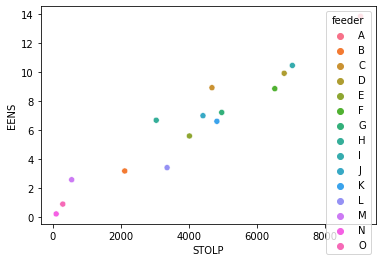

In [ ]:
grouppedby_feeder = df.groupby('feeder').sum().drop('BN',1)
grouppedby_feeder['feeder'] = grouppedby_feeder.index
sns.scatterplot(data=grouppedby_feeder,x='STOLP',y='EENS',hue='feeder')
plt.show()

## 1.5 Time Between Failure of The System (TBF)

In [ ]:
times = df.DFB.sort_values()
mean = datetime.timedelta(0)
for i in range(len(times)-1):
    mean += times[i+1]-times[i]
print(f'TBF of The System: {mean/len(times)}')

TBF of The System: 0 days 05:18:25.615524560


## 1.6 Time Between Failure with Respect to Feeder (TBF)

TBF of feeder (A): 1 days 22:27:17.553191489
TBF of feeder (B): 6 days 07:58:07.777777777
TBF of feeder (C): 2 days 01:23:45.423728813
TBF of feeder (D): 1 days 21:19:10.366492146
TBF of feeder (E): 3 days 15:56:24.242424242
TBF of feeder (F): 2 days 14:31:31.510791366
TBF of feeder (G): 2 days 19:52:56.718750
TBF of feeder (H): 2 days 21:57:53.709677419
TBF of feeder (I): 1 days 20:38:18.652849740
TBF of feeder (J): 3 days 00:19:42.564102564
TBF of feeder (K): 2 days 08:37:32.368421052
TBF of feeder (L): 6 days 12:24:44.444444444
TBF of feeder (M): 17 days 19:57:06.666666666
TBF of feeder (N): 36 days 02:05:37.500000
TBF of feeder (O): 40 days 19:44:51.428571428


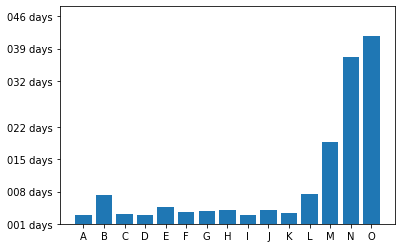

In [10]:
TBFs= []
for feeder in cats:
    times = df[df.feeder==feeder].DFB.sort_values().reset_index(drop=True)
    mean = datetime.timedelta(0)
    for i in range(len(times)-1):
        mean += times[i+1] - times[i]
    print(f'TBF of feeder ({feeder}): {mean/len(times)}')
    TBFs.append(mean/len(times))

zero = datetime.datetime(2018,1,1)
time = [zero + t for t in TBFs]
zero = mdates.date2num(zero)
time = [t-zero for t in mdates.date2num(time)]
f = plt.figure()
ax = f.add_subplot(1,1,1)
ax.bar(cats, time, bottom=zero)
ax.yaxis_date()
ax.yaxis.set_major_formatter(mdates.DateFormatter("%j days"))
ylim = ax.get_ylim()
ax.set_ylim(None, ylim[1]+0.1*np.diff(ylim))

plt.show()

## 1.7 STOLP vs DOFDB

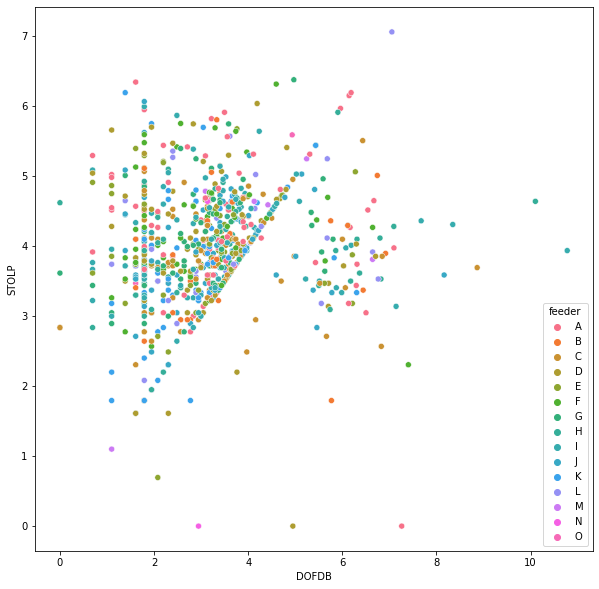

In [ ]:
plt.figure(figsize=(10,10))
logdf = df.copy()
logdf.STOLP = np.log(logdf.STOLP+1)
logdf.DOFDB = np.log(logdf.DOFDB+1)
sns.scatterplot(data=logdf,x='DOFDB',y='STOLP',hue='feeder')
plt.show()

## 1.8 Histogram of STOLP

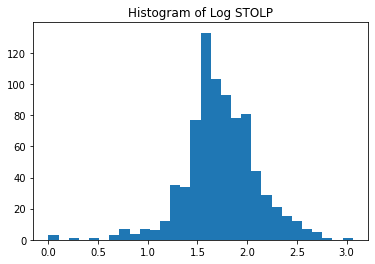

In [12]:
plt.hist(np.log10(df.STOLP+1),bins=30)
plt.title('Histogram of Log STOLP')
plt.show()

## 1.9 Histogram of DOFDB

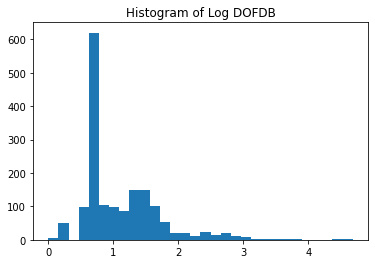

In [11]:
plt.hist(np.log10(df.DOFDB+1),bins=30)
plt.title('Histogram of Log DOFDB')
plt.show()

## 1.10 DFB Histogram (ROCOF)

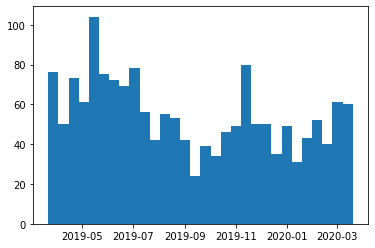

In [ ]:
plt.hist(df.DFB,bins=30)
plt.show()